# RAG Metrics Analysis

This notebook analyzes different configurations and their impact on RAG performance metrics.

In [101]:
import pandas as pd
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
with open('final_results_mb3.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

df.columns = [col.replace('parameters.', '').replace('metrics.', '') for col in df.columns]

df.head()

,chunk_size,strategy,context_retrieval,overlap_size,embeddings,faithfulness,answer_relevancy,answer_similarity,answer_correctness,context_precision,context_recall
0,500,recursive_text_splitter,True,0,bge-m3,0.509385,0.870967,0.907118,0.430039,0.967742,0.967742
1,500,recursive_text_splitter,True,100,bge-m3,0.619302,0.904919,0.918326,0.473882,0.966667,0.996667
2,500,recursive_text_splitter,False,0,bge-m3,0.549608,0.905357,0.912237,0.479805,0.967742,0.967742
3,500,recursive_text_splitter,False,100,bge-m3,0.686156,0.800599,0.903462,0.500205,0.933333,0.941667
4,800,recursive_text_splitter,True,0,bge-m3,0.577886,0.731412,0.895188,0.379130,0.965517,0.965517


## Overall Metrics Distribution

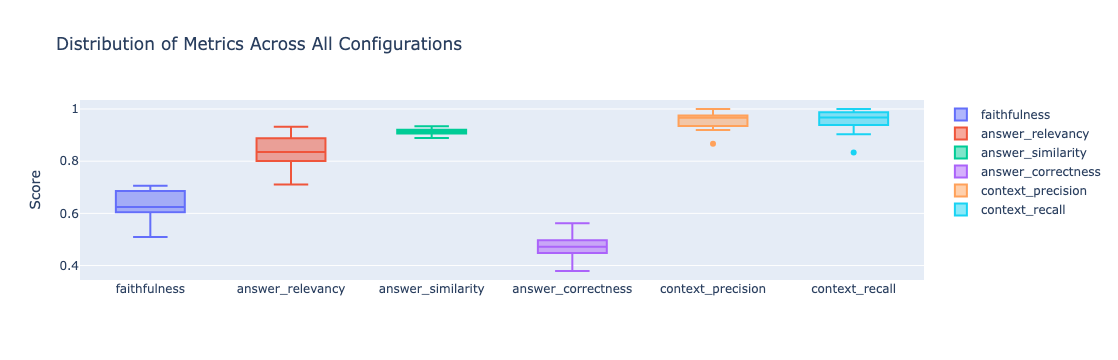

In [91]:
metric_cols = ['faithfulness', 'answer_relevancy', 'answer_similarity', 'answer_correctness', 
               'context_precision', 'context_recall']

fig = go.Figure()
for col in metric_cols:
    fig.add_trace(go.Box(y=df[col], name=col))

fig.update_layout(
    title='Distribution of Metrics Across All Configurations',
    yaxis_title='Score',
    showlegend=True,
    height=600
)
fig.show()

## Impact of Chunk Size

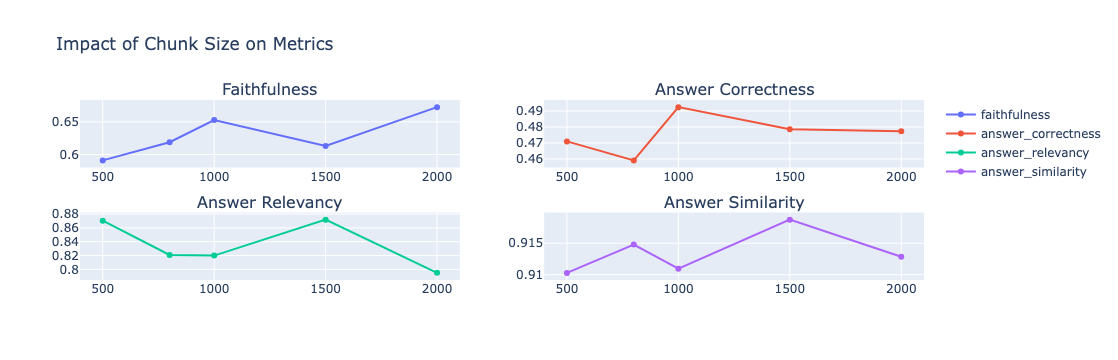

In [109]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Faithfulness', 'Answer Correctness', 
                                                    'Answer Relevancy', 'Answer Similarity'))

metrics = ['faithfulness', 'answer_correctness', 'answer_relevancy', 'answer_similarity']
positions = [(1,1), (1,2), (2,1), (2,2)]

for metric, pos in zip(metrics, positions):
    avg_by_chunk = df.groupby('chunk_size')[metric].mean()
    fig.add_trace(
        go.Scatter(x=avg_by_chunk.index, y=avg_by_chunk.values, mode='lines+markers',
                  name=metric),
        row=pos[0], col=pos[1]
    )

fig.update_layout(height=800, title_text="Impact of Chunk Size on Metrics")
fig.show()

## Context Retrieval Analysis

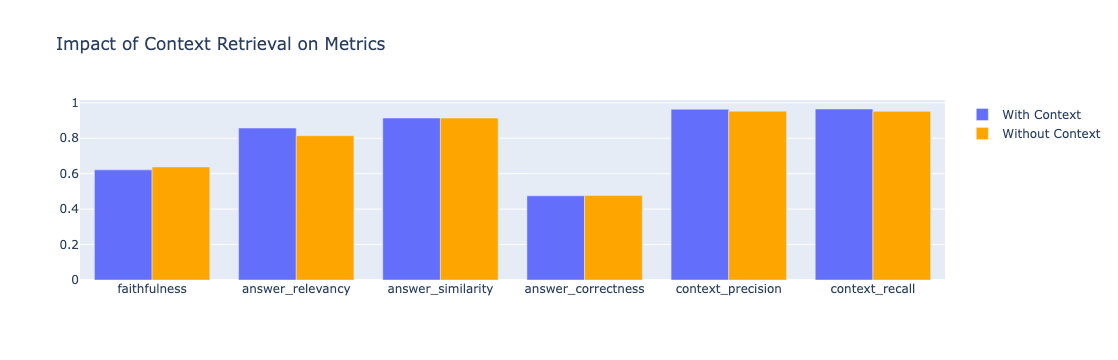

In [72]:
context_comparison = df.groupby('context_retrieval')[metric_cols].mean()

fig = go.Figure(data=[
    go.Bar(name='With Context', x=metric_cols, y=context_comparison.loc[True]),
    go.Bar(name='Without Context', x=metric_cols, y=context_comparison.loc[False], marker_color='orange')
])

fig.update_layout(
    title='Impact of Context Retrieval on Metrics',
    barmode='group',
    height=500
)
fig.show()

## Overlap Size Impact

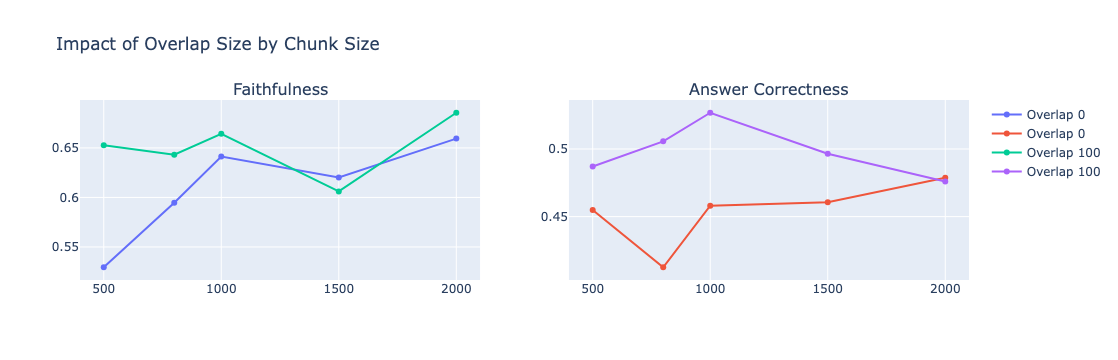

In [74]:
overlap_impact = df.pivot_table(
    index='chunk_size',
    columns='overlap_size',
    values=['faithfulness', 'answer_correctness'],
    aggfunc='mean'
)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Faithfulness', 'Answer Correctness'))

for overlap in df['overlap_size'].unique():
    fig.add_trace(
        go.Scatter(
            x=overlap_impact.index,
            y=overlap_impact[('faithfulness', overlap)],
            name=f'Overlap {overlap}',
            mode='lines+markers'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=overlap_impact.index,
            y=overlap_impact[('answer_correctness', overlap)],
            name=f'Overlap {overlap}',
            mode='lines+markers'
        ),
        row=1, col=2
    )

fig.update_layout(height=500, title_text="Impact of Overlap Size by Chunk Size")
fig.show()

## Best Configurations

In [79]:
best_configs = pd.DataFrame()

for metric in metric_cols:
    best_idx = df[metric].idxmax()
    best_configs[metric] = df.loc[best_idx, ['chunk_size', 'context_retrieval', 
                                             'overlap_size', 'faithfulness']]

print("Best Configurations by Metric:")
best_configs.T

Best Configurations by Metric:


,chunk_size,context_retrieval,overlap_size,faithfulness
faithfulness,1500,True,0,0.705972
answer_relevancy,800,True,100,0.611396
answer_similarity,800,False,100,0.674747
answer_correctness,800,False,100,0.674747
context_precision,800,False,100,0.674747
context_recall,800,True,100,0.611396


## Correlation Analysis

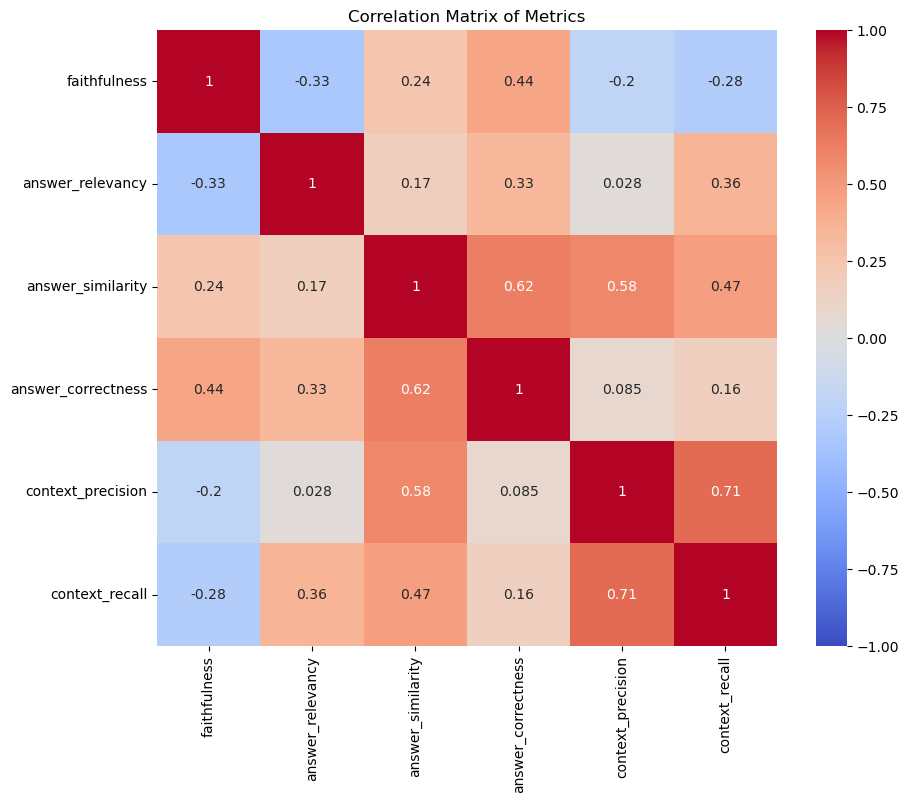

In [82]:
correlation = df[metric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Metrics')
plt.show()

## Configuration Recommendations

In [89]:
weights = {
    'faithfulness': 0.25,
    'answer_correctness': 0,
    'answer_relevancy': 0.25,
    'answer_similarity': 0,
    'context_precision': 0.25,
    'context_recall': 0.25
}

df['weighted_score'] = sum(df[metric] * weight for metric, weight in weights.items())

top_configs = df.nlargest(5, 'weighted_score')[['chunk_size', 'context_retrieval', 
                                                'overlap_size', 'weighted_score'] + metric_cols]

print("Top 5 Recommended Configurations:")
top_configs

Top 5 Recommended Configurations:


,chunk_size,context_retrieval,overlap_size,weighted_score,faithfulness,answer_relevancy,answer_similarity,answer_correctness,context_precision,context_recall
12,1500,True,0,0.881271,0.705972,0.869111,0.923803,0.479410,0.983333,0.966667
9,1000,True,100,0.879985,0.637869,0.928736,0.920360,0.560781,0.966667,0.986667
5,800,True,100,0.877538,0.611396,0.932090,0.905537,0.448827,0.966667,1.000000
13,1500,True,100,0.872390,0.596524,0.927518,0.931811,0.543160,0.965517,1.000000
1,500,True,100,0.871889,0.619302,0.904919,0.918326,0.473882,0.966667,0.996667
